In [5]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

In [6]:
!kaggle datasets download -d moonfallidk/bug-bite-images

Dataset URL: https://www.kaggle.com/datasets/moonfallidk/bug-bite-images
License(s): apache-2.0
bug-bite-images.zip: Skipping, found more recently modified local copy (use --force to force download)


In [7]:
import zipfile
zip_ref = zipfile.ZipFile('/content/bug-bite-images.zip', 'r')
zip_ref.extractall('/content')
zip_ref.close()

In [8]:
import os
import numpy as np
from PIL import Image
from tqdm import tqdm
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight

In [9]:
data_path = '/content'
train_path = os.path.join(data_path, 'training')
test_path = os.path.join(data_path, 'testing')
validation_path = os.path.join(data_path, 'skin_of_color_testing')

In [10]:
def load_and_preprocess_images(folder_path, target_size=(224, 224)):
    images = []
    labels = []
    for root, _, files in os.walk(folder_path):
        for file in tqdm(files, desc=f"Processing {os.path.basename(root)}"):
            if file.lower().endswith(('.png', '.jpg', '.jpeg')):
                img_path = os.path.join(root, file)
                try:
                    img = Image.open(img_path).convert('RGB')  # Ensure 3 channels
                    img = img.resize(target_size)
                    img_array = np.array(img) / 255.0  # Normalize to [0, 1]
                    images.append(img_array)
                    labels.append(os.path.basename(root))
                except Exception as e:
                    print(f"Error processing {img_path}: {str(e)}")
    return np.array(images), np.array(labels)

In [11]:
print("Loading and preprocessing images...")
train_images, train_labels = load_and_preprocess_images(train_path)
test_images, test_labels = load_and_preprocess_images(test_path)
validation_images, validation_labels = load_and_preprocess_images(validation_path)

Loading and preprocessing images...


Processing training: 0it [00:00, ?it/s]
Processing .comments: 100%|██████████| 15/15 [00:00<00:00, 162150.93it/s]
Processing testing: 0it [00:00, ?it/s]
Processing .comments: 100%|██████████| 1/1 [00:00<00:00, 10922.67it/s]
Processing skin_of_color_testing: 0it [00:00, ?it/s]
Processing .comments: 100%|██████████| 1/1 [00:00<00:00, 465.62it/s]


In [12]:
class_indices = {cls: i for i, cls in enumerate(np.unique(train_labels))}
num_classes = len(class_indices)

In [13]:
train_labels_cat = to_categorical([class_indices[label] for label in train_labels], num_classes=num_classes)
test_labels_cat = to_categorical([class_indices[label] for label in test_labels], num_classes=num_classes)
validation_labels_cat = to_categorical([class_indices[label] for label in validation_labels], num_classes=num_classes)

In [14]:
class_weights = compute_class_weight('balanced', classes=np.unique(train_labels), y=train_labels)
class_weight_dict = dict(enumerate(class_weights))

In [15]:
train_images, val_images, train_labels_cat, val_labels_cat = train_test_split(
    train_images, train_labels_cat, test_size=0.2, random_state=42, stratify=train_labels)

In [16]:
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal_and_vertical"),
    layers.RandomRotation(0.2),
    layers.RandomZoom(0.2),
    layers.RandomTranslation(0.2, 0.2),
])

In [17]:
input_shape = (224, 224, 3)
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=input_shape)

inputs = layers.Input(shape=input_shape)
x = data_augmentation(inputs)
x = base_model(x, training=False)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(256, activation='relu')(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(num_classes, activation='softmax')(x)

model = models.Model(inputs, outputs)

# Freeze the base model layers
base_model.trainable = False

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [18]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [19]:
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)           │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ sequential (Sequential)              │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ mobilenetv2_1.00_224 (Functional)    │ (None, 7, 7, 1280)          │       2,257,984 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 1280)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 256)                 │         327,936 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 8)                   │           2,056 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,587,976 (9.87 MB)

 Trainable params: 329,992 (1.26 MB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [20]:
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss', factor=0.2, patience=5, min_lr=1e-6)

In [21]:
print("Training the model...")
history = model.fit(
    train_images, train_labels_cat,
    validation_data=(val_images, val_labels_cat),
    epochs=100,
    batch_size=32,
    class_weight=class_weight_dict,
    callbacks=[early_stopping, reduce_lr]
)

Training the model...
Epoch 1/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 16s 215ms/step - accuracy: 0.1366 - loss: 2.5132 - val_accuracy: 0.1706 - val_loss: 2.0246 - learning_rate: 1.0000e-04
Epoch 2/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 76ms/step - accuracy: 0.1462 - loss: 2.2297 - val_accuracy: 0.2891 - val_loss: 1.8997 - learning_rate: 1.0000e-04
Epoch 3/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 75ms/step - accuracy: 0.2004 - loss: 2.0507 - val_accuracy: 0.3602 - val_loss: 1.7939 - learning_rate: 1.0000e-04
Epoch 4/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 75ms/step - accuracy: 0.2714 - loss: 1.9567 - val_accuracy: 0.4028 - val_loss: 1.7348 - learning_rate: 1.0000e-04
Epoch 5/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 3s 73ms/step - accuracy: 0.3185 - loss: 1.8440 - val_accuracy: 0.4218 - val_loss: 1.6693 - learning_rate: 1.0000e-04
Epoch 6/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 84ms/step - accuracy: 0.3231 - loss: 1.8134 - val_accuracy: 0.4265 - val_loss: 1.6315 - learning_rate: 1.0000e-04
Epoch 7/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 2

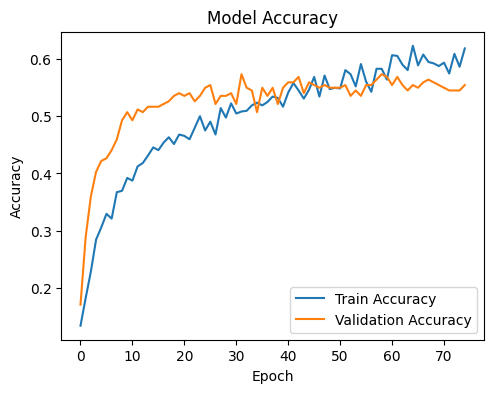

In [22]:
# Plot training history
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

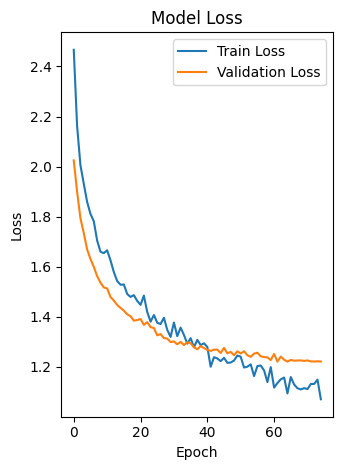

In [23]:
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

In [24]:
# Evaluate the model on the test set
print("Evaluating the model on the test set...")
test_loss, test_accuracy = model.evaluate(test_images, test_labels_cat)
print(f"Test accuracy: {test_accuracy:.4f}")
print(f"Test loss: {test_loss:.4f}")

Evaluating the model on the test set...
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 121ms/step - accuracy: 0.6200 - loss: 1.0914
Test accuracy: 0.5887
Test loss: 1.1357


In [28]:
from tensorflow.keras.models import save_model

# Save the model to a Keras-native format
save_model(model, 'insect_bite_classification_model.keras')
print("Model saved as 'insect_bite_classification_model.keras'")

Model saved as 'insect_bite_classification_model.keras'
